### Uncertainty analysis
Using the Monte Carlo Simulations method

In [28]:
import numpy as np
import rasterio as rio
import smca_model
from tqdm import tqdm

In [2]:
# Load the rasters
ksat = rio.open('Rasters/ksat.tif')
wcs = rio.open('Rasters/wcs.tif')
alt_dev = rio.open('Rasters/alt-dev.tif')

In [3]:
# Convert rasters to numpy arrays
ksat_data = ksat.read()
wcs_data = wcs.read()
alt_dev_data = alt_dev.read()


In [4]:
weights = [0.43, 0.14, 0.43]

# Define the type for each criterion
# '1' for benefit, '0' for cost
types = [1, 1, 0]

In [ ]:
def mcs_simulation(ksat_data, wcs_data, alt_dev_data, weights, types, n_simulations=10, std_dev=0.1):
    # Get the shape of the input data (assuming they are 3D arrays with the same shape)
    data_shape = ksat_data.shape[1:]  # This will give (3422, 3398)

    # Initialize an array to store the results of each simulation
    results = np.zeros((n_simulations, *data_shape))  # Shape: (n_simulations, 3422, 3398)

    for i in tqdm(range(n_simulations)):
        # Generate random weights from a normal distribution centered at the original weights
        random_weights = np.random.normal(weights, std_dev)

        # Ensure weights are positive (since weights can't be negative)
        random_weights = np.abs(random_weights)

        # Normalize weights so they sum to 1
        random_weights = random_weights / np.sum(random_weights)

        # Run the smca_model with the random weights
        result = smca_model.model(ksat_data, wcs_data, alt_dev_data, random_weights, types)

        # Set values below a certain threshold to NaN (e.g., -100)
        result[result < -100] = np.nan

        # Store the result
        results[i] = result

    # Calculate statistics from the results
    min_rank = np.min(results, axis=0)
    max_rank = np.max(results, axis=0)
    average_rank = np.mean(results, axis=0)
    std_dev_rank = np.std(results, axis=0)

    return min_rank, max_rank, average_rank, std_dev_rank

In [35]:
# Example usage:
min_rank, max_rank, average_rank, std_dev_rank = mcs_simulation(
    ksat_data, wcs_data, alt_dev_data, weights, types, n_simulations=10, std_dev=0.1
)

100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


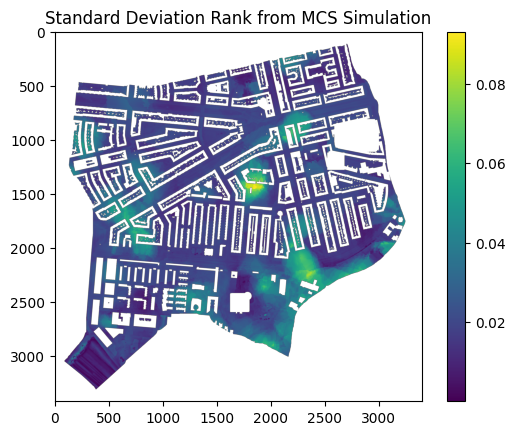

In [36]:
# Plot min_rank
# You can then analyze or plot these results as needed
# For example, using matplotlib to visualize the average_rank
# Set nodata values to NaN for better visualization
import matplotlib.pyplot as plt
plt.imshow(std_dev_rank, cmap='viridis')
plt.colorbar()
plt.title('Standard Deviation Rank from MCS Simulation')
plt.show()